<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Code" data-toc-modified-id="Code-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Code</a></span></li><li><span><a href="#Configuration" data-toc-modified-id="Configuration-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Configuration</a></span></li><li><span><a href="#Fixed-Parameters" data-toc-modified-id="Fixed-Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Fixed Parameters</a></span></li><li><span><a href="#Loading-Data" data-toc-modified-id="Loading-Data-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Loading Data</a></span></li><li><span><a href="#Optimization" data-toc-modified-id="Optimization-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Optimization</a></span><ul class="toc-item"><li><span><a href="#No-HC-Charging" data-toc-modified-id="No-HC-Charging-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>No HC Charging</a></span></li><li><span><a href="#Detailed-Days-Report" data-toc-modified-id="Detailed-Days-Report-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Detailed Days Report</a></span></li><li><span><a href="#Full-Year-Report" data-toc-modified-id="Full-Year-Report-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Full Year Report</a></span></li></ul></li></ul></div>

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from itertools import product
from datetime import datetime

In [2]:
DEBUG = True

### Code

In [3]:
def load_and_prepare_data(
    import_file,
    columns_map):
    
    df = pd.read_csv(import_file)

    # First, reverse the columns_map dictionary to map old names to new names
    reverse_columns_map = {v: k for k, v in columns_map.items()}

    # Now rename the columns using the reversed mapping
    df = df.rename(columns=reverse_columns_map)

    # Set Index
    df['time_stamp'] = pd.to_datetime(df['time_stamp'], format='%m/%d/%Y %H:%M')

    # Set the datetime column as the index
    df.set_index('time_stamp', inplace=True)

    # Ensure the index is sorted chronologically
    df.sort_index(inplace=True)
    
    return df

In [4]:
def rescale_solar_production(
    df_original,
    original_capacity,
    new_capacity):
    
    """
    Rescale solar production data from original PV capacity to new PV capacity.

    Assumptions:
    1. Solar production scales linearly with panel capacity
    2. Consumption remains the same
    3. Export is increased production minus any additional self-consumption
    4. Import is reduced by any additional self-consumption

    Parameters:
    df_original (pd.DataFrame): Original DataFrame with energy data
    original_capacity (float): Original solar capacity in kWc
    new_capacity (float): New solar capacity in kWc

    Returns:
    pd.DataFrame: New DataFrame with rescaled values
    """
    
    if original_capacity == new_capacity:
        return df_original.copy()
    
    # Make a copy of the original dataframe to avoid modifying it
    df = df_original.copy()

    # Calculate scaling factor
    scaling_factor = new_capacity / original_capacity

    # Rescale produced_wh (solar production scales directly with panel capacity)
    df['produced_wh'] = df['produced_wh'] * scaling_factor

    # Calculate how much additional energy is now produced
    additional_production = df['produced_wh'] - df_original['produced_wh']

    # Calculate how much of this additional production can be self-consumed
    # This is the minimum between additional production and what would have been imported
    potential_self_consumption = df_original['imported_wh']
    additional_self_consumption = np.minimum(additional_production, potential_self_consumption)

    # Calculate new values for imported_wh and exported_wh
    # Imported energy decreases by the additional self-consumption
    df['imported_wh'] = df_original['imported_wh'] - additional_self_consumption
    df['imported_wh'] = df['imported_wh'].clip(lower=0)  # Can't have negative imports

    # Exported energy is original export plus any additional production not self-consumed
    df['exported_wh'] = df_original['exported_wh'] + (additional_production - additional_self_consumption)

    # Consumed energy stays the same (assumption in the problem statement)
    # But let's verify that energy balance still makes sense
    # Total energy available = produced + imported (from grid)
    # Total energy used = consumed + exported (to grid)
    # The difference between these should be zero

    # Return the rescaled dataframe
    return df

In [5]:
def simulate_battery(
    df,
    wh_price_sale_eur,
    wh_price_high_eur,
    wh_price_low_eur,
    subscription_monthly_fee_eur,
    max_battery_capacity_wh,
    battery_discharge_lower_limit_pc=10,
    battery_charge_upper_limit_pc=90,
    battery_efficiency_pc=95,
    max_battery_charge_rate_w=None,
    max_battery_discharge_rate_w=None,
    enable_hc_charging=True,
):
    """
    Simulate the addition of a battery to the solar panel system with updated charge/discharge logic and battery efficiency.
    Parameters:
    - df: pandas DataFrame with columns produced_wh, consumed_wh, exported_wh, imported_wh, and time_stamp as the index.
    - max_battery_capacity_wh: Maximum capacity of the battery in Wh.
    - wh_price_sale_eur: Price at which excess energy is sold back to the grid (€/Wh).
    - wh_price_high_eur: Price of energy during high-price periods (€/Wh).
    - wh_price_low_eur: Price of energy during low-price periods (€/Wh).
    - subscription_monthly_fee_eur: Fixed monthly subscription fee (€).
    - battery_discharge_lower_limit_pc: Minimum SOC percentage (0-25).
    - battery_charge_upper_limit_pc: Maximum SOC percentage (75-100).
    - battery_efficiency_pc: Battery round-trip efficiency percentage (0-100).
    - enable_hc_charging: Boolean flag to enable/disable battery charging from grid during HC periods.
    Returns:
    - total_cost_no_solar: Total annual cost without solar panels (€).
    - total_cost_with_solar: Total annual cost with solar panels but no battery (€).
    - total_cost_with_solar_battery: Cost with solar and battery, with grid recharging during HC controlled by enable_hc_charging flag.
    - df_with_battery: DataFrame with additional columns for battery operations and costs.
    """
    # Validate new parameters
    if not (0 <= battery_discharge_lower_limit_pc <= 25):
        raise ValueError("battery_discharge_lower_limit_pc must be between 0 and 25")
    if not (75 <= battery_charge_upper_limit_pc <= 100):
        raise ValueError("battery_charge_upper_limit_pc must be between 75 and 100")
    if not (0 <= battery_efficiency_pc <= 100):
        raise ValueError("battery_efficiency_pc must be between 0 and 100")
    # Calculate battery limits in Wh
    battery_discharge_lower_limit_wh = max_battery_capacity_wh * battery_discharge_lower_limit_pc / 100
    battery_charge_upper_limit_wh = max_battery_capacity_wh * battery_charge_upper_limit_pc / 100
    # Initialize battery parameters
    if max_battery_charge_rate_w is None:
        max_battery_charge_rate_w = 2*max_battery_capacity_wh / 3
    if max_battery_discharge_rate_w is None:
        max_battery_discharge_rate_w = 2*max_battery_capacity_wh / 3
    max_charge_rate_wh = max_battery_charge_rate_w / 4  # Convert to Wh per 15 minutes
    max_discharge_rate_wh = max_battery_discharge_rate_w / 4  # Convert to Wh per 15 minutes
    # Initialize costs
    total_cost_no_solar = 0
    total_cost_with_solar = 0
    total_cost_with_solar_battery = 0
    # Calculate the fixed cost per 15-minute interval
    fixed_cost_per_interval = (12 * subscription_monthly_fee_eur) / (365 * 24 * 4)
    # Make a copy of the dataframe to avoid modifying the original
    df = df.copy()
    # Add columns to store the results of the simulation
    df['battery_charge_solar_wh'] = 0.0
    df['battery_charge_grid_wh'] = 0.0
    df['battery_discharge_wh'] = 0.0
    df['net_imported_wh'] = 0.0
    df['net_exported_wh'] = 0.0
    df['cost_eur'] = 0.0
    df['battery_soc'] = 0.0  # To track battery SOC over time
    df['cost_no_solar'] = 0.0
    df['cost_with_solar'] = 0.0
    # Initialize battery state
    battery_soc = 0
    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        time_stamp = index
        produced_wh = row['produced_wh']
        consumed_wh = row['consumed_wh']
        # Determine if the current time is HP or HC
        hour = time_stamp.hour
        is_high_price = 7 <= hour < 23  # HP from 7:00 to 23:00
        current_price = wh_price_high_eur if is_high_price else wh_price_low_eur
        # Calculate cost without solar panels (all consumption from grid)
        cost_no_solar = consumed_wh * current_price + fixed_cost_per_interval
        total_cost_no_solar += cost_no_solar
        df.at[index, 'cost_no_solar'] = cost_no_solar
        # Calculate cost with solar panels but no battery
        net_energy = produced_wh - consumed_wh
        if net_energy > 0:
            # Excess solar that would be exported to the grid
            exported_wh_no_battery = net_energy
            imported_wh_no_battery = 0
        else:
            # Deficit that would be imported from the grid
            exported_wh_no_battery = 0
            imported_wh_no_battery = -net_energy
        cost_with_solar = (imported_wh_no_battery * current_price) - (exported_wh_no_battery * wh_price_sale_eur) + fixed_cost_per_interval
        total_cost_with_solar += cost_with_solar
        df.at[index, 'cost_with_solar'] = cost_with_solar
        # ===== Scenario: With Battery =====
        # Initialize variables
        battery_charge_solar = 0
        battery_charge_grid = 0
        battery_discharge = 0
        net_imported = 0
        net_exported = 0
        # Calculate net energy before battery
        net_energy = produced_wh - consumed_wh

        # Case 1: Deficit (solar production < consumption)
        if net_energy < 0:
            energy_needed = -net_energy
            # Try to cover deficit with battery discharge
            available_energy = max(0, battery_soc - battery_discharge_lower_limit_wh)
            potential_discharge = min(energy_needed, max_discharge_rate_wh, available_energy)
            if potential_discharge > 0:
                soc_decrease = potential_discharge / (battery_efficiency_pc / 100)
                battery_discharge = potential_discharge
                battery_soc -= soc_decrease
                remaining_deficit = energy_needed - potential_discharge
            else:
                remaining_deficit = energy_needed

            # Any remaining deficit is imported from the grid
            if remaining_deficit > 0:
                net_imported = remaining_deficit

        # Case 2: Excess (solar production > consumption)
        elif net_energy > 0:
            # Use excess to charge battery
            max_possible_charge = min(net_energy, max_charge_rate_wh)
            space_available = battery_charge_upper_limit_wh - battery_soc
            if space_available <= 0:
                potential_charge = 0
            else:
                potential_charge = min(max_possible_charge, space_available)
            if potential_charge > 0:
                soc_increase = potential_charge * battery_efficiency_pc / 100
                battery_charge_solar = potential_charge
                battery_soc += soc_increase
                # Remaining excess is exported to the grid
                remaining_excess = net_energy - potential_charge
                if remaining_excess > 0:
                    net_exported = remaining_excess

        # In HC periods, if enabled, charge from grid if there's room
        if not is_high_price and enable_hc_charging and battery_soc < battery_charge_upper_limit_wh:
            space_available = battery_charge_upper_limit_wh - battery_soc
            max_possible_charge = min(space_available, max_charge_rate_wh)
            if max_possible_charge > 0:
                soc_increase = max_possible_charge * battery_efficiency_pc / 100
                battery_charge_grid = max_possible_charge
                battery_soc += soc_increase
                net_imported += battery_charge_grid  # Grid energy used to charge battery

        # Clamp battery SOC within physical limits
        battery_soc = max(0, min(battery_soc, max_battery_capacity_wh))
        # Also ensure SOC stays within operational limits
        battery_soc = max(battery_discharge_lower_limit_wh, min(battery_soc, battery_charge_upper_limit_wh))

        # Calculate cost for the battery scenario
        cost_with_battery = 0
        if net_imported > 0:
            cost_with_battery += net_imported * current_price
        if net_exported > 0:
            cost_with_battery -= net_exported * wh_price_sale_eur
        cost_with_battery += fixed_cost_per_interval
        total_cost_with_solar_battery += cost_with_battery

        # Update the DataFrame with the battery scenario results
        df.at[index, 'battery_charge_solar_wh'] = battery_charge_solar
        df.at[index, 'battery_charge_grid_wh'] = battery_charge_grid
        df.at[index, 'battery_discharge_wh'] = battery_discharge
        df.at[index, 'net_imported_wh'] = net_imported
        df.at[index, 'net_exported_wh'] = net_exported
        df.at[index, 'battery_soc'] = battery_soc
        df.at[index, 'cost_eur'] = cost_with_battery

    return (
        total_cost_no_solar,
        total_cost_with_solar,
        total_cost_with_solar_battery,
        df
    )


In [6]:
def simulate_battery_v2(
    df,
    max_battery_capacity_wh,
    battery_discharge_lower_limit_pc,
    battery_charge_upper_limit_pc,
    battery_efficiency_pc,
    max_battery_charge_rate_w,
    max_battery_discharge_rate_w,
    enable_hc_charging,
):
    """
    Simulate the addition of a battery to the solar panel system with updated charge/discharge logic and battery efficiency.
    This version focuses only on tracking energy flows between components.

    Parameters:
    - df: pandas DataFrame with columns produced_wh, consumed_wh, and time_stamp as the index.
    - max_battery_capacity_wh: Maximum capacity of the battery in Wh.
    - battery_discharge_lower_limit_pc: Minimum SOC percentage (0-25).
    - battery_charge_upper_limit_pc: Maximum SOC percentage (75-100).
    - battery_efficiency_pc: Battery round-trip efficiency percentage (0-100).
    - max_battery_charge_rate_w: Maximum charge rate in watts.
    - max_battery_discharge_rate_w: Maximum discharge rate in watts.
    - enable_hc_charging: Boolean flag to enable/disable battery charging from grid during HC periods.

    Returns:
    - df_with_battery: DataFrame with columns tracking energy flows between components.
    """
    # Validate parameters
    if not (0 <= battery_discharge_lower_limit_pc <= 25):
        raise ValueError("battery_discharge_lower_limit_pc must be between 0 and 25")
    if not (75 <= battery_charge_upper_limit_pc <= 100):
        raise ValueError("battery_charge_upper_limit_pc must be between 75 and 100")
    if not (0 <= battery_efficiency_pc <= 100):
        raise ValueError("battery_efficiency_pc must be between 0 and 100")

    # Calculate battery limits in Wh
    battery_discharge_lower_limit_wh = max_battery_capacity_wh * battery_discharge_lower_limit_pc / 100
    battery_charge_upper_limit_wh = max_battery_capacity_wh * battery_charge_upper_limit_pc / 100

    # Initialize battery parameters
    if max_battery_charge_rate_w is None:
        max_battery_charge_rate_w = 2 * max_battery_capacity_wh / 3
    if max_battery_discharge_rate_w is None:
        max_battery_discharge_rate_w = 2 * max_battery_capacity_wh / 3

    max_charge_rate_wh = max_battery_charge_rate_w / 4  # Convert to Wh per 15 minutes
    max_discharge_rate_wh = max_battery_discharge_rate_w / 4  # Convert to Wh per 15 minutes

    # Make a copy of the dataframe to avoid modifying the original
    df = df.copy()

    # Add columns to store the energy flow results
    df['Grid > House'] = 0.0
    df['Grid > Battery'] = 0.0
    df['Solar > House'] = 0.0
    df['Battery > House'] = 0.0
    df['Solar > Battery'] = 0.0
    df['Solar > Grid'] = 0.0
    df['Battery SOC'] = 0.0

    # Initialize battery state
    battery_soc = 0

    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        time_stamp = index
        produced_wh = row['produced_wh']
        consumed_wh = row['consumed_wh']

        # Determine if the current time is HP or HC
        hour = time_stamp.hour
        is_high_price = 7 <= hour < 23  # HP from 7:00 to 23:00

        # Initialize energy flow variables for this time period
        grid_to_house = 0
        grid_to_battery = 0
        solar_to_house = 0
        battery_to_house = 0
        solar_to_battery = 0
        solar_to_grid = 0

        # Calculate Solar > House (direct solar consumption)
        solar_to_house = min(produced_wh, consumed_wh)

        # Calculate net energy (what's left after solar directly powers house)
        net_energy = produced_wh - consumed_wh

        # Case 1: Deficit (solar production < consumption)
        if net_energy < 0:
            energy_needed = -net_energy

            # Try to cover deficit with battery discharge (Battery > House)
            available_energy = max(0, battery_soc - battery_discharge_lower_limit_wh)
            potential_discharge = min(energy_needed, max_discharge_rate_wh, available_energy)

            if potential_discharge > 0:
                soc_decrease = potential_discharge / (battery_efficiency_pc / 100)
                battery_to_house = potential_discharge
                battery_soc -= soc_decrease
                remaining_deficit = energy_needed - potential_discharge
            else:
                remaining_deficit = energy_needed

            # Any remaining deficit comes from grid to house (Grid > House)
            if remaining_deficit > 0:
                grid_to_house = remaining_deficit

        # Case 2: Excess (solar production > consumption)
        elif net_energy > 0:
            # Use excess to charge battery (Solar > Battery)
            max_possible_charge = min(net_energy, max_charge_rate_wh)
            space_available = battery_charge_upper_limit_wh - battery_soc

            if space_available <= 0:
                potential_charge = 0
            else:
                potential_charge = min(max_possible_charge, space_available)

            if potential_charge > 0:
                soc_increase = potential_charge * battery_efficiency_pc / 100
                solar_to_battery = potential_charge
                battery_soc += soc_increase

                # Remaining excess is exported to the grid (Solar > Grid)
                remaining_excess = net_energy - potential_charge
                if remaining_excess > 0:
                    solar_to_grid = remaining_excess
            else:
                # If no battery charging, all excess goes to grid
                solar_to_grid = net_energy

        # Clamp battery SOC after solar operations but before grid charging
        battery_soc = max(0, min(battery_soc, max_battery_capacity_wh))
        battery_soc = max(battery_discharge_lower_limit_wh, min(battery_soc, battery_charge_upper_limit_wh))

        # In HC periods, if enabled, charge from grid if there's room (Grid > Battery)
        if not is_high_price and enable_hc_charging:
            space_available = battery_charge_upper_limit_wh - battery_soc
            if space_available > 0:
                max_possible_charge = min(space_available, max_charge_rate_wh)
                if max_possible_charge > 0:
                    soc_increase = max_possible_charge * battery_efficiency_pc / 100
                    grid_to_battery = max_possible_charge
                    battery_soc += soc_increase

        # Final clamp (for safety, though theoretically not needed now)
        battery_soc = max(0, min(battery_soc, max_battery_capacity_wh))
        battery_soc = max(battery_discharge_lower_limit_wh, min(battery_soc, battery_charge_upper_limit_wh))

        # Update the DataFrame with the energy flow results
        df.at[index, 'Grid > House'] = grid_to_house
        df.at[index, 'Grid > Battery'] = grid_to_battery
        df.at[index, 'Solar > House'] = solar_to_house
        df.at[index, 'Battery > House'] = battery_to_house
        df.at[index, 'Solar > Battery'] = solar_to_battery
        df.at[index, 'Solar > Grid'] = solar_to_grid
        df.at[index, 'Battery SOC'] = battery_soc

    return df

In [7]:
def optimize_capacity(
    df,
    wh_price_sale_eur,
    wh_price_high_eur,
    wh_price_low_eur,
    subscription_monthly_fee_eur,
    original_solar_capacity,
    solar_capacities_w,
    battery_capacities_wh,
    battery_discharge_lower_limit_pc=5,
    battery_charge_upper_limit_pc=95,
    battery_efficiency_pc=95,
    enable_hc_charging=True,
):

    results = []

    for solar_capacity, battery_capacity in product(solar_capacities_w, battery_capacities_wh):
        
        # Rescale solar production
        scaled_df = rescale_solar_production(
            df,
            original_solar_capacity,
            solar_capacity)

        raw, with_solar, with_solar_battery, d = simulate_battery(
            scaled_df,
            wh_price_sale_eur,
            wh_price_high_eur,
            wh_price_low_eur,
            subscription_monthly_fee_eur,
            battery_capacity,
            battery_discharge_lower_limit_pc=battery_discharge_lower_limit_pc,
            battery_charge_upper_limit_pc=battery_charge_upper_limit_pc,
            battery_efficiency_pc=battery_efficiency_pc,
            max_battery_charge_rate_w=None,
            max_battery_discharge_rate_w=None,
            enable_hc_charging=enable_hc_charging,
        )
        
        result = {
            'solar_capacity': solar_capacity,
            'battery_capacity': battery_capacity,
            'cost_raw': raw,
            'cost_with_solar': with_solar,
            'cost_with_solar_battery': with_solar_battery,
            'data': d,
        }
        
        results.append(result)

        if DEBUG:
            print(f'--------------------------------------------------------------------')
            print(f'solar       -> {int(solar_capacity/1000.0)}kWc')
            print(f'battery     -> {int(battery_capacity/1000.0)}kWh')
            print(f'HC charging -> {enable_hc_charging}')
            print(f'')
            print(f'total_cost: {int(raw)} €')
            print(f'total_cost_with_solar: {int(with_solar)} €')
            print(f'total_cost_with_solar_battery: {int(with_solar_battery)} €')
            print(f'--------------------------------------------------------------------')
            print(f'')
            print(f'')


    return results

In [8]:
def optimize_capacity_v2(
    df,
    wh_price_sale_eur,
    wh_price_high_eur,
    wh_price_low_eur,
    subscription_monthly_fee_eur,
    original_solar_capacity,
    solar_capacities_w,
    battery_capacities_wh,
    battery_discharge_lower_limit_pc,
    battery_charge_upper_limit_pc,
    battery_efficiency_pc,
    enable_hc_charging,
):

    results = []

    for solar_capacity, battery_capacity in product(solar_capacities_w, battery_capacities_wh):
        
        # Rescale solar production
        scaled_df = rescale_solar_production(
            df,
            original_solar_capacity,
            solar_capacity)

        simulated_df = simulate_battery_v2(
            scaled_df,
#            wh_price_sale_eur,
#            wh_price_high_eur,
#            wh_price_low_eur,
#            subscription_monthly_fee_eur,
            battery_capacity,
            battery_discharge_lower_limit_pc,
            battery_charge_upper_limit_pc,
            battery_efficiency_pc,
            max_battery_charge_rate_w=None,
            max_battery_discharge_rate_w=None,
            enable_hc_charging=enable_hc_charging,
        )
        
        result = {
            'solar_capacity': solar_capacity,
            'battery_capacity': battery_capacity,
            'data': simulated_df,
        }
        
        results.append(result)

        if DEBUG:
            print(f'--------------------------------------------------------------------')
            print(f'solar       -> {int(solar_capacity/1000.0)}kWc')
            print(f'battery     -> {int(battery_capacity/1000.0)}kWh')
            print(f'HC charging -> {enable_hc_charging}')
            print(f'--------------------------------------------------------------------')
            print(f'')
            print(f'')

    return results

In [9]:
def plot_battery_soc(
    df,
    start_date,
    end_date,
    wh_price_high_eur,
    wh_price_low_eur,
    wh_price_sale_eur,
    subscription_monthly_fee_eur=0,
    plot_chart=True):
    """
    Plot the battery SOC and charging/discharging activities over a specified time period.
    Includes vertical bands to highlight HC (low-cost) periods and customized x-axis ticks.
    Also returns financial totals for the period (in kWh) including solar and battery savings.
    Parameters:
    - df: DataFrame returned by simulate_battery function.
    - start_date: Start date and time in "YYYY-MM-DD HH:MM:SS" format.
    - end_date: End date and time in "YYYY-MM-DD HH:MM:SS" format.
    - wh_price_high_eur: Cost per Wh during HP periods (7AM-11PM)
    - wh_price_low_eur: Cost per Wh during HC periods (11PM-7AM)
    - wh_price_sale_eur: Price per Wh for selling excess solar
    - subscription_monthly_fee_eur: Monthly subscription fee in EUR (default 0)
    - plot_chart: Boolean whether to show the chart at all (default True)
    Returns:
    - A DataFrame with financial totals for the period (in kWh) including solar and battery savings
    """
    from datetime import datetime
    import pandas as pd
    import matplotlib.pyplot as plt
    from matplotlib.dates import DayLocator, HourLocator, DateFormatter
    # Convert start_date and end_date to datetime objects
    try:
        start_date = pd.Timestamp(datetime.strptime(start_date, "%Y-%m-%d %H:%M:%S"))
    except ValueError:
        start_date = pd.Timestamp(datetime.strptime(start_date, "%Y-%m-%d"))
    try:
        end_date = pd.Timestamp(datetime.strptime(end_date, "%Y-%m-%d %H:%M:%S"))
    except ValueError:
        end_date = pd.Timestamp(datetime.strptime(end_date, "%Y-%m-%d"))
    # Filter the DataFrame to include only rows within the date range
    mask = (df.index >= start_date) & (df.index <= end_date)
    filtered_df = df.loc[mask].copy()
    
    if filtered_df.empty:
        print("No data found in the specified date range.")
        return None
    # Calculate additional metrics for plotting and calculations
    filtered_df.loc[:, 'solar_consumed_wh'] = filtered_df.apply(
        lambda row: min(row['produced_wh'], row['consumed_wh']),
        axis=1)
    # New: Calculate grid consumption based on priority rules
    filtered_df.loc[:, 'solar_to_house'] = filtered_df.apply(
        lambda row: min(row['produced_wh'], row['consumed_wh']), axis=1)
    filtered_df.loc[:, 'remaining_cons'] = filtered_df['consumed_wh'] - filtered_df['solar_to_house']
    filtered_df.loc[:, 'grid_to_house'] = filtered_df.apply(
        lambda row: max(0, row['remaining_cons'] - row['battery_discharge_wh']), axis=1)
    # Use our recalculated grid_to_house instead of the original calculation
    filtered_df.loc[:, 'grid_consumed_wh'] = filtered_df['grid_to_house']
    filtered_df.loc[:, 'solar_exported_wh'] = filtered_df['net_exported_wh']
    # Determine HP/HC periods
    hours = filtered_df.index.hour
    filtered_df['is_hp'] = (hours >= 7) & (hours < 23)
    filtered_df['is_hc'] = ~filtered_df['is_hp']
    # Calculate fixed cost per interval
    num_intervals = len(filtered_df)
    if num_intervals > 0:
        fixed_cost_per_interval = (12 * subscription_monthly_fee_eur) / (365 * 24 * 4)
    else:
        fixed_cost_per_interval = 0
    # Only create the plot if plot_chart is True
    if plot_chart:
        # Create a figure and axis for plotting
        fig, ax = plt.subplots(figsize=(16, 10))
        # Plot the SOC level with updated style
        ax.plot(
            filtered_df.index,
            filtered_df['battery_soc'],
            label='Battery SOC',
            color='grey',  # Lighter color
            linestyle=':',  # Dotted line
            linewidth=1.5)
        # Plot the total consumption line
        ax.plot(
            filtered_df.index,
            filtered_df['consumed_wh'],
            label='Consumed',
            color='darkgrey',
            linewidth=1.5)
        ax.set_xlabel('Time')
        ax.set_ylabel('Energy (Wh)')
        ax.set_title('Battery State of Charge (SOC) and Energy Flows')
        ax.grid(True)
        # Add vertical bands for HC periods
        timestamps = filtered_df.index.to_pydatetime()
        is_hc = filtered_df['is_hc'].tolist()
        hc_ranges = []
        current_range_start = None
        for i in range(len(timestamps)):
            if is_hc[i]:
                if current_range_start is None:
                    current_range_start = timestamps[i]
            else:
                if current_range_start is not None:
                    hc_ranges.append((current_range_start, timestamps[i-1]))
                    current_range_start = None
        if current_range_start is not None:
            hc_ranges.append((current_range_start, timestamps[-1]))
        for start, end in hc_ranges:
            ax.axvspan(start, end, color='lightgrey', alpha=0.3, linewidth=0)
        # Define the width of the bars
        width = 0.01
        # Plot positive bars (stacking up)
        # 1. Grid > House
        ax.bar(
            filtered_df.index,
            filtered_df['grid_consumed_wh'],
            width=width,
            color='lightblue',
            label='Grid > House',
            alpha=0.7)
        bottom = filtered_df['grid_consumed_wh']
        # 2. Grid > Battery
        ax.bar(
            filtered_df.index,
            filtered_df['battery_charge_grid_wh'],
            width=width,
            color='blue',
            label='Grid > Battery',
            alpha=0.7,
            bottom=bottom)
        bottom += filtered_df['battery_charge_grid_wh']
        # 3. Solar > House
        ax.bar(
            filtered_df.index,
            filtered_df['solar_consumed_wh'],
            width=width,
            color='lightgreen',
            label='Solar > House',
            alpha=0.7,
            bottom=bottom)
        bottom += filtered_df['solar_consumed_wh']
        # 4. Battery > House (now light red)
        ax.bar(
            filtered_df.index,
            filtered_df['battery_discharge_wh'],
            width=width,
            color='lightcoral',  # Changed from red to light red
            label='Battery > House',
            alpha=0.7,
            bottom=bottom)
        # Plot negative bars (stacking down)
        # 1. Solar > Battery
        ax.bar(
            filtered_df.index,
            -filtered_df['battery_charge_solar_wh'],
            width=width,
            color='green',
            label='Solar > Battery',
            alpha=0.7)
        # 2. Solar > Grid (now red instead of light red)
        ax.bar(
            filtered_df.index,
            -filtered_df['solar_exported_wh'],
            width=width,
            color='red',  # Changed from lightcoral to red
            label='Solar > Grid',
            alpha=0.7,
            bottom=-filtered_df['battery_charge_solar_wh'])
        # Set up x-axis formatting with major and minor ticks
        ax.xaxis.set_major_locator(DayLocator())
        ax.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))
        ax.xaxis.set_minor_locator(HourLocator(interval=3))
        ax.xaxis.set_minor_formatter(DateFormatter("%H:%M"))
        plt.xticks(rotation=45, ha='right')
        ax.tick_params(which='major', length=8, labelsize=10)
        ax.tick_params(which='minor', length=4, labelsize=8, color='gray')
        from matplotlib.patches import Patch
        legend_elements = ax.get_legend_handles_labels()
        handles = legend_elements[0]
        labels = legend_elements[1]
        handles.append(Patch(facecolor='lightgrey', alpha=0.3, linewidth=0))
        labels.append('HC Periods')
        ax.legend(handles, labels, loc='upper right')
        plt.tight_layout()
        plt.show()
    # Initialize results dictionary with all categories with updated names
    results = {
        'Grid > House': {'hp_cost': 0, 'hp_wh': 0, 'hc_cost': 0, 'hc_wh': 0},
        'Battery > House': {'hp_cost': 0, 'hp_wh': 0, 'hc_cost': 0, 'hc_wh': 0},
        'Solar > Grid': {'hp_cost': 0, 'hp_wh': 0, 'hc_cost': 0, 'hc_wh': 0},
        'Grid > Battery': {'hp_cost': 0, 'hp_wh': 0, 'hc_cost': 0, 'hc_wh': 0},
        'Solar > House': {'hp_cost': 0, 'hp_wh': 0, 'hc_cost': 0, 'hc_wh': 0},
        'Solar > Battery': {'hp_cost': 0, 'hp_wh': 0, 'hc_cost': 0, 'hc_wh': 0},
        'Solar Savings': {'hp_cost': 0, 'hp_wh': 0, 'hc_cost': 0, 'hc_wh': 0},
        'Battery Savings': {'hp_cost': 0, 'hp_wh': 0, 'hc_cost': 0, 'hc_wh': 0},
        'Subscription Fee': {'hp_cost': 0, 'hp_wh': 0, 'hc_cost': 0, 'hc_wh': 0}
    }
    # Helper function to calculate cost based on period and category
    def calculate_cost(row, category, wh_column):
        wh = row[wh_column]
        if wh == 0:
            return
        if category == 'Solar > Grid':
            # This is income from selling solar, so negative cost
            cost = wh * wh_price_sale_eur * -1
            if row['is_hp']:
                results[category]['hp_cost'] += cost
                results[category]['hp_wh'] += -wh
            else:
                results[category]['hc_cost'] += cost
                results[category]['hc_wh'] += -wh
        elif category == 'Solar > Battery':
            # Cost of storing solar instead of selling it
            cost = wh * wh_price_sale_eur  # Positive cost since we're not selling
            if row['is_hp']:
                results[category]['hp_cost'] += cost
                results[category]['hp_wh'] += wh
            else:
                results[category]['hc_cost'] += cost
                results[category]['hc_wh'] += wh
        elif category in ['Grid > House', 'Grid > Battery']:
            if row['is_hp']:
                rate = wh_price_high_eur
                period = 'hp'
            else:
                rate = wh_price_low_eur
                period = 'hc'
            cost = wh * rate
            results[category][f'{period}_cost'] += cost
            results[category][f'{period}_wh'] += wh
        elif category == 'Battery > House':
            if row['is_hp']:
                rate = wh_price_high_eur
                period = 'hp'
            else:
                rate = wh_price_low_eur
                period = 'hc'
            cost = wh * rate * -1
            results[category][f'{period}_cost'] += cost
            results[category][f'{period}_wh'] += -wh
        elif category == 'Solar > House':
            if row['is_hp']:
                rate = wh_price_high_eur
                period = 'hp'
            else:
                rate = wh_price_low_eur
                period = 'hc'
            cost = wh * rate * -1
            results[category][f'{period}_cost'] += cost
            results[category][f'{period}_wh'] += -wh
    # Process each row to accumulate the totals
    for _, row in filtered_df.iterrows():
        calculate_cost(row, 'Grid > House', 'grid_consumed_wh')
        calculate_cost(row, 'Battery > House', 'battery_discharge_wh')
        calculate_cost(row, 'Solar > Grid', 'solar_exported_wh')
        calculate_cost(row, 'Grid > Battery', 'battery_charge_grid_wh')
        calculate_cost(row, 'Solar > House', 'solar_consumed_wh')
        # Handle solar charge separately
        wh = row['battery_charge_solar_wh']
        if wh > 0:
            if row['is_hp']:
                period = 'hp'
            else:
                period = 'hc'
            results['Solar > Battery'][f'{period}_wh'] += wh
            cost = wh * wh_price_sale_eur  # Cost of not selling this energy
            results['Solar > Battery'][f'{period}_cost'] += cost
    # Calculate fixed costs
    if num_intervals > 0:
        total_fixed_cost = fixed_cost_per_interval * num_intervals
        num_hp_intervals = filtered_df['is_hp'].sum()
        num_hc_intervals = num_intervals - num_hp_intervals
        if num_hp_intervals > 0:
            results['Subscription Fee']['hp_cost'] = (total_fixed_cost * num_hp_intervals) / num_intervals
        if num_hc_intervals > 0:
            results['Subscription Fee']['hc_cost'] = (total_fixed_cost * num_hc_intervals) / num_intervals
    # Calculate savings correctly
    # Battery Savings = Grid > Battery (cost) + Solar > Battery (cost) + Battery > House (negative cost)
    # Solar Savings = - (Solar > Grid + Solar > House)
    # Reset savings calculations
    results['Battery Savings'] = {'hp_cost': 0, 'hp_wh': 0, 'hc_cost': 0, 'hc_wh': 0}
    results['Solar Savings'] = {'hp_cost': 0, 'hp_wh': 0, 'hc_cost': 0, 'hc_wh': 0}
    # Calculate Battery Savings: Grid > Battery + Solar > Battery + Battery > House
    for period in ['hp', 'hc']:
        grid_to_battery = results['Grid > Battery'][f'{period}_cost']
        solar_to_battery = results['Solar > Battery'][f'{period}_cost']
        battery_to_house = results['Battery > House'][f'{period}_cost']
        # Total battery savings is the sum of these components
        total_cost = grid_to_battery + solar_to_battery + battery_to_house
        total_wh = (results['Grid > Battery'][f'{period}_wh'] +
                    results['Solar > Battery'][f'{period}_wh'] +
                    results['Battery > House'][f'{period}_wh'])
        results['Battery Savings'][f'{period}_cost'] = total_cost
        results['Battery Savings'][f'{period}_wh'] = total_wh
    # Calculate Solar Savings: - (Solar > Grid + Solar > House)
    for period in ['hp', 'hc']:
        solar_to_grid = results['Solar > Grid'][f'{period}_cost']
        solar_to_house = results['Solar > House'][f'{period}_cost']
        total_cost = solar_to_grid + solar_to_house
        total_wh = results['Solar > Grid'][f'{period}_wh'] + results['Solar > House'][f'{period}_wh']
        results['Solar Savings'][f'{period}_cost'] = total_cost
        results['Solar Savings'][f'{period}_wh'] = total_wh
    # Calculate totals
    # 1. Total Consumed (Any > House)
    total_consumed_hp_wh = (results['Grid > House']['hp_wh'] +
                           results['Solar > House']['hp_wh'] +
                           results['Battery > House']['hp_wh'])
    total_consumed_hc_wh = (results['Grid > House']['hc_wh'] +
                           results['Solar > House']['hc_wh'] +
                           results['Battery > House']['hc_wh'])
    total_consumed_hp_cost = (results['Grid > House']['hp_cost'] +
                             results['Solar > House']['hp_cost'] +
                             results['Battery > House']['hp_cost'])
    total_consumed_hc_cost = (results['Grid > House']['hc_cost'] +
                             results['Solar > House']['hc_cost'] +
                             results['Battery > House']['hc_cost'])
    # 2. Total Stored (Any > Battery)
    total_stored_hp_wh = (results['Grid > Battery']['hp_wh'] +
                         results['Solar > Battery']['hp_wh'])
    total_stored_hc_wh = (results['Grid > Battery']['hc_wh'] +
                         results['Solar > Battery']['hc_wh'])
    total_stored_hp_cost = (results['Grid > Battery']['hp_cost'] +
                           results['Solar > Battery']['hp_cost'])
    total_stored_hc_cost = (results['Grid > Battery']['hc_cost'] +
                           results['Solar > Battery']['hc_cost'])
    # 3. Total Produced (Solar > Any)
    total_produced_hp_wh = (results['Solar > Battery']['hp_wh'] +
                           results['Solar > Grid']['hp_wh'] +
                           results['Solar > House']['hp_wh'])
    total_produced_hc_wh = (results['Solar > Battery']['hc_wh'] +
                           results['Solar > Grid']['hc_wh'] +
                           results['Solar > House']['hc_wh'])
    total_produced_hp_cost = (results['Solar > Battery']['hp_cost'] +
                             results['Solar > Grid']['hp_cost'] +
                             results['Solar > House']['hp_cost'])
    total_produced_hc_cost = (results['Solar > Battery']['hc_cost'] +
                             results['Solar > Grid']['hc_cost'] +
                             results['Solar > House']['hc_cost'])
    # 4. Total Imported (Grid > Any)
    total_imported_hp_wh = (results['Grid > House']['hp_wh'] +
                           results['Grid > Battery']['hp_wh'])
    total_imported_hc_wh = (results['Grid > House']['hc_wh'] +
                           results['Grid > Battery']['hc_wh'])
    total_imported_hp_cost = (results['Grid > House']['hp_cost'] +
                             results['Grid > Battery']['hp_cost'])
    total_imported_hc_cost = (results['Grid > House']['hc_cost'] +
                             results['Grid > Battery']['hc_cost'])
    # 5. All Savings (sum of both savings)
    all_savings_hp_cost = results['Solar Savings']['hp_cost'] + results['Battery Savings']['hp_cost']
    all_savings_hc_cost = results['Solar Savings']['hc_cost'] + results['Battery Savings']['hc_cost']
    all_savings_hp_wh = results['Solar Savings']['hp_wh'] + results['Battery Savings']['hp_wh']
    all_savings_hc_wh = results['Solar Savings']['hc_wh'] + results['Battery Savings']['hc_wh']
    # Add our new totals
    # Total Exported (Any > Grid) - currently just Solar > Grid
    total_exported_hp_wh = results['Solar > Grid']['hp_wh']
    total_exported_hc_wh = results['Solar > Grid']['hc_wh']
    total_exported_hp_cost = results['Solar > Grid']['hp_cost']
    total_exported_hc_cost = results['Solar > Grid']['hc_cost']
    # Total Cost
    total_cost_hp_cost = (total_imported_hp_cost +
                         results['Subscription Fee']['hp_cost'] +
                         total_exported_hp_cost)
    total_cost_hc_cost = (total_imported_hc_cost +
                         results['Subscription Fee']['hc_cost'] +
                         total_exported_hc_cost)
    total_cost_hp_wh = (total_imported_hp_wh +
                       total_exported_hp_wh)
    total_cost_hc_wh = (total_imported_hc_wh +
                       total_exported_hc_wh)
    # Add totals and savings to results
    results.update({
        'Total Consumed (Any > House)': {
            'hp_cost': total_consumed_hp_cost,
            'hp_wh': total_consumed_hp_wh,
            'hc_cost': total_consumed_hc_cost,
            'hc_wh': total_consumed_hc_wh
        },
        'Total Stored (Any > Battery)': {
            'hp_cost': total_stored_hp_cost,
            'hp_wh': total_stored_hp_wh,
            'hc_cost': total_stored_hc_cost,
            'hc_wh': total_stored_hc_wh
        },
        'Total Produced (Solar > Any)': {
            'hp_cost': total_produced_hp_cost,
            'hp_wh': total_produced_hp_wh,
            'hc_cost': total_produced_hc_cost,
            'hc_wh': total_produced_hc_wh
        },
        'Total Imported (Grid > Any)': {
            'hp_cost': total_imported_hp_cost,
            'hp_wh': total_imported_hp_wh,
            'hc_cost': total_imported_hc_cost,
            'hc_wh': total_imported_hc_wh
        },
        'Total Exported (Any > Grid)': {
            'hp_cost': total_exported_hp_cost,
            'hp_wh': total_exported_hp_wh,
            'hc_cost': total_exported_hc_cost,
            'hc_wh': total_exported_hc_wh
        },
        'Total Cost': {
            'hp_cost': total_cost_hp_cost,
            'hp_wh': total_cost_hp_wh,
            'hc_cost': total_cost_hc_cost,
            'hc_wh': total_cost_hc_wh
        },
        'All Savings': {
            'hp_cost': all_savings_hp_cost,
            'hp_wh': all_savings_hp_wh,
            'hc_cost': all_savings_hc_cost,
            'hc_wh': all_savings_hc_wh
        }
    })
    # Create lists to build the DataFrame with hierarchical index
    data = []
    # Metrics section
    metric_order = [
        'Grid > House',
        'Grid > Battery',
        'Solar > House',
        'Battery > House',
        'Solar > Battery',
        'Solar > Grid',
        'Subscription Fee'
    ]
    for name in metric_order:
        if name in results:
            item = results[name]
            data.append({
                'Category': 'Metric',
                'Type': name,
                'HP Cost': round(item['hp_cost'], 2),
                'HP kWh': round(item['hp_wh'] / 1000, 2),
                'HC Cost': round(item['hc_cost'], 2),
                'HC kWh': round(item['hc_wh'] / 1000, 2),
                'Total Cost': round(item['hp_cost'] + item['hc_cost'], 2),
                'Total kWh': round((item['hp_wh'] + item['hc_wh']) / 1000, 2)
            })
    # Totals section
    totals_order = [
        'Total Imported (Grid > Any)',
        'Total Exported (Any > Grid)',
        'Total Consumed (Any > House)',
        'Total Stored (Any > Battery)',
        'Total Produced (Solar > Any)',
        'Total Cost'
    ]
    for name in totals_order:
        if name in results:
            item = results[name]
            data.append({
                'Category': 'Total',
                'Type': name,
                'HP Cost': round(item['hp_cost'], 2),
                'HP kWh': round(item['hp_wh'] / 1000, 2),
                'HC Cost': round(item['hc_cost'], 2),
                'HC kWh': round(item['hc_wh'] / 1000, 2),
                'Total Cost': round(item['hp_cost'] + item['hc_cost'], 2),
                'Total kWh': round((item['hp_wh'] + item['hc_wh']) / 1000, 2)
            })
    # Savings section
    savings_order = ['Solar Savings', 'Battery Savings', 'All Savings']
    for name in savings_order:
        if name in results:
            item = results[name]
            data.append({
                'Category': 'Savings',
                'Type': name,
                'HP Cost': round(item['hp_cost'], 2),
                'HP kWh': round(item['hp_wh'] / 1000, 2),
                'HC Cost': round(item['hc_cost'], 2),
                'HC kWh': round(item['hc_wh'] / 1000, 2),
                'Total Cost': round(item['hp_cost'] + item['hc_cost'], 2),
                'Total kWh': round((item['hp_wh'] + item['hc_wh']) / 1000, 2)
            })
    # Create DataFrame and set hierarchical index
    results_df = pd.DataFrame(data)
    results_df = results_df.set_index(['Category', 'Type'])
    # Sort the index to have Metrics first, then Totals, then Savings
    results_df = results_df.sort_index(level=0, sort_remaining=False)
    
    return results_df

In [10]:
def plot_battery_soc_v2(
    df,
    start_date,
    end_date,
    wh_price_high_eur,
    wh_price_low_eur,
    wh_price_sale_eur,
    subscription_monthly_fee_eur=0,
    plot_chart=True):
    """
    Plot the battery SOC and charging/discharging activities over a specified time period.
    This version is adapted to work with the output of simulate_battery_v2.
    """
    from datetime import datetime
    import pandas as pd
    import matplotlib.pyplot as plt
    from matplotlib.dates import DayLocator, HourLocator, DateFormatter

    # Convert start_date and end_date to datetime objects (same as original)
    try:
        start_date = pd.Timestamp(datetime.strptime(start_date, "%Y-%m-%d %H:%M:%S"))
    except ValueError:
        start_date = pd.Timestamp(datetime.strptime(start_date, "%Y-%m-%d"))
    try:
        end_date = pd.Timestamp(datetime.strptime(end_date, "%Y-%m-%d %H:%M:%S"))
    except ValueError:
        end_date = pd.Timestamp(datetime.strptime(end_date, "%Y-%m-%d"))

    # Filter the DataFrame to include only rows within the date range
    mask = (df.index >= start_date) & (df.index <= end_date)
    filtered_df = df.loc[mask].copy()

    if filtered_df.empty:
        print("No data found in the specified date range.")
        return None

    # Determine HP/HC periods (same as original)
    hours = filtered_df.index.hour
    filtered_df['is_hp'] = (hours >= 7) & (hours < 23)
    filtered_df['is_hc'] = ~filtered_df['is_hp']

    # Calculate fixed cost per interval (same as original)
    num_intervals = len(filtered_df)
    if num_intervals > 0:
        fixed_cost_per_interval = (12 * subscription_monthly_fee_eur) / (365 * 24 * 4)
    else:
        fixed_cost_per_interval = 0

    # Only create the plot if plot_chart is True
    if plot_chart:
        # Create a figure and axis for plotting (same as original)
        fig, ax = plt.subplots(figsize=(16, 10))

        # Plot the SOC level with updated style (same as original)
        ax.plot(
            filtered_df.index,
            filtered_df['Battery SOC'],
            label='Battery SOC',
            color='grey',
            linestyle=':',
            linewidth=1.5)

        # Plot the total consumption line (this might need adjustment)
        ax.plot(
            filtered_df.index,
            filtered_df['consumed_wh'],
            label='Consumed',
            color='darkgrey',
            linewidth=1.5)

        ax.set_xlabel('Time')
        ax.set_ylabel('Energy (Wh)')
        ax.set_title('Battery State of Charge (SOC) and Energy Flows')
        ax.grid(True)

        # Add vertical bands for HC periods (same as original)
        timestamps = filtered_df.index.to_pydatetime()
        is_hc = filtered_df['is_hc'].tolist()
        hc_ranges = []
        current_range_start = None
        for i in range(len(timestamps)):
            if is_hc[i]:
                if current_range_start is None:
                    current_range_start = timestamps[i]
            else:
                if current_range_start is not None:
                    hc_ranges.append((current_range_start, timestamps[i-1]))
                    current_range_start = None
        if current_range_start is not None:
            hc_ranges.append((current_range_start, timestamps[-1]))
        for start, end in hc_ranges:
            ax.axvspan(start, end, color='lightgrey', alpha=0.3, linewidth=0)

        # Define the width of the bars (same as original)
        width = 0.01

        # Plot positive bars (stacking up)
        # 1. Grid > House (replaces grid_consumed_wh)
        ax.bar(
            filtered_df.index,
            filtered_df['Grid > House'],
            width=width,
            color='lightblue',
            label='Grid > House',
            alpha=0.7)
        bottom = filtered_df['Grid > House']

        # 2. Grid > Battery (replaces battery_charge_grid_wh)
        ax.bar(
            filtered_df.index,
            filtered_df['Grid > Battery'],
            width=width,
            color='blue',
            label='Grid > Battery',
            alpha=0.7,
            bottom=bottom)
        bottom += filtered_df['Grid > Battery']

        # 3. Solar > House (replaces solar_consumed_wh)
        ax.bar(
            filtered_df.index,
            filtered_df['Solar > House'],
            width=width,
            color='lightgreen',
            label='Solar > House',
            alpha=0.7,
            bottom=bottom)
        bottom += filtered_df['Solar > House']

        # 4. Battery > House (replaces battery_discharge_wh)
        ax.bar(
            filtered_df.index,
            filtered_df['Battery > House'],
            width=width,
            color='lightcoral',
            label='Battery > House',
            alpha=0.7,
            bottom=bottom)

        # Plot negative bars (stacking down)
        # 1. Solar > Battery (replaces battery_charge_solar_wh)
        ax.bar(
            filtered_df.index,
            -filtered_df['Solar > Battery'],
            width=width,
            color='green',
            label='Solar > Battery',
            alpha=0.7)

        # 2. Solar > Grid (replaces solar_exported_wh)
        ax.bar(
            filtered_df.index,
            -filtered_df['Solar > Grid'],
            width=width,
            color='red',
            label='Solar > Grid',
            alpha=0.7,
            bottom=-filtered_df['Solar > Battery'])

        # Set up x-axis formatting with major and minor ticks (same as original)
        ax.xaxis.set_major_locator(DayLocator())
        ax.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))
        ax.xaxis.set_minor_locator(HourLocator(interval=3))
        ax.xaxis.set_minor_formatter(DateFormatter("%H:%M"))
        plt.xticks(rotation=45, ha='right')
        ax.tick_params(which='major', length=8, labelsize=10)
        ax.tick_params(which='minor', length=4, labelsize=8, color='gray')

        from matplotlib.patches import Patch
        legend_elements = ax.get_legend_handles_labels()
        handles = legend_elements[0]
        labels = legend_elements[1]
        handles.append(Patch(facecolor='lightgrey', alpha=0.3, linewidth=0))
        labels.append('HC Periods')
        ax.legend(handles, labels, loc='upper right')
        plt.tight_layout()
        plt.show()

    # Initialize results dictionary with all categories with updated names
    results = {
        'Grid > House': {'hp_cost': 0, 'hp_wh': 0, 'hc_cost': 0, 'hc_wh': 0},
        'Battery > House': {'hp_cost': 0, 'hp_wh': 0, 'hc_cost': 0, 'hc_wh': 0},
        'Solar > Grid': {'hp_cost': 0, 'hp_wh': 0, 'hc_cost': 0, 'hc_wh': 0},
        'Grid > Battery': {'hp_cost': 0, 'hp_wh': 0, 'hc_cost': 0, 'hc_wh': 0},
        'Solar > House': {'hp_cost': 0, 'hp_wh': 0, 'hc_cost': 0, 'hc_wh': 0},
        'Solar > Battery': {'hp_cost': 0, 'hp_wh': 0, 'hc_cost': 0, 'hc_wh': 0},
        'Solar Savings': {'hp_cost': 0, 'hp_wh': 0, 'hc_cost': 0, 'hc_wh': 0},
        'Battery Savings': {'hp_cost': 0, 'hp_wh': 0, 'hc_cost': 0, 'hc_wh': 0},
        'Subscription Fee': {'hp_cost': 0, 'hp_wh': 0, 'hc_cost': 0, 'hc_wh': 0}
    }

    # Helper function to calculate cost based on period and category
    def calculate_cost(row, category, wh_column):
        wh = row[wh_column]
        if wh == 0:
            return
        if category == 'Solar > Grid':
            # This is income from selling solar, so negative cost
            cost = wh * wh_price_sale_eur * -1
            if row['is_hp']:
                results[category]['hp_cost'] += cost
                results[category]['hp_wh'] += -wh
            else:
                results[category]['hc_cost'] += cost
                results[category]['hc_wh'] += -wh
        elif category == 'Solar > Battery':
            # Cost of storing solar instead of selling it
            cost = wh * wh_price_sale_eur  # Positive cost since we're not selling
            if row['is_hp']:
                results[category]['hp_cost'] += cost
                results[category]['hp_wh'] += wh
            else:
                results[category]['hc_cost'] += cost
                results[category]['hc_wh'] += wh
        elif category in ['Grid > House', 'Grid > Battery']:
            if row['is_hp']:
                rate = wh_price_high_eur
                period = 'hp'
            else:
                rate = wh_price_low_eur
                period = 'hc'
            cost = wh * rate
            results[category][f'{period}_cost'] += cost
            results[category][f'{period}_wh'] += wh
        elif category == 'Battery > House':
            if row['is_hp']:
                rate = wh_price_high_eur
                period = 'hp'
            else:
                rate = wh_price_low_eur
                period = 'hc'
            cost = wh * rate * -1
            results[category][f'{period}_cost'] += cost
            results[category][f'{period}_wh'] += -wh
        elif category == 'Solar > House':
            if row['is_hp']:
                rate = wh_price_high_eur
                period = 'hp'
            else:
                rate = wh_price_low_eur
                period = 'hc'
            cost = wh * rate * -1
            results[category][f'{period}_cost'] += cost
            results[category][f'{period}_wh'] += -wh

    # Process each row to accumulate the totals
    for _, row in filtered_df.iterrows():
        calculate_cost(row, 'Grid > House', 'Grid > House')
        calculate_cost(row, 'Battery > House', 'Battery > House')
        calculate_cost(row, 'Solar > Grid', 'Solar > Grid')
        calculate_cost(row, 'Grid > Battery', 'Grid > Battery')
        calculate_cost(row, 'Solar > House', 'Solar > House')

        # Handle solar charge separately (already handled in the above line)
        wh = row['Solar > Battery']
        if wh > 0:
            if row['is_hp']:
                period = 'hp'
            else:
                period = 'hc'
            results['Solar > Battery'][f'{period}_wh'] += wh
            cost = wh * wh_price_sale_eur  # Cost of not selling this energy
            results['Solar > Battery'][f'{period}_cost'] += cost

    # Calculate fixed costs (same as original)
    if num_intervals > 0:
        total_fixed_cost = fixed_cost_per_interval * num_intervals
        num_hp_intervals = filtered_df['is_hp'].sum()
        num_hc_intervals = num_intervals - num_hp_intervals
        if num_hp_intervals > 0:
            results['Subscription Fee']['hp_cost'] = (total_fixed_cost * num_hp_intervals) / num_intervals
        if num_hc_intervals > 0:
            results['Subscription Fee']['hc_cost'] = (total_fixed_cost * num_hc_intervals) / num_intervals

    # Calculate savings correctly (same as original)
    # Battery Savings = Grid > Battery (cost) + Solar > Battery (cost) + Battery > House (negative cost)
    # Solar Savings = - (Solar > Grid + Solar > House)
    # Reset savings calculations
    results['Battery Savings'] = {'hp_cost': 0, 'hp_wh': 0, 'hc_cost': 0, 'hc_wh': 0}
    results['Solar Savings'] = {'hp_cost': 0, 'hp_wh': 0, 'hc_cost': 0, 'hc_wh': 0}

    # Calculate Battery Savings: Grid > Battery + Solar > Battery + Battery > House
    for period in ['hp', 'hc']:
        grid_to_battery = results['Grid > Battery'][f'{period}_cost']
        solar_to_battery = results['Solar > Battery'][f'{period}_cost']
        battery_to_house = results['Battery > House'][f'{period}_cost']
        # Total battery savings is the sum of these components
        total_cost = grid_to_battery + solar_to_battery + battery_to_house
        total_wh = (results['Grid > Battery'][f'{period}_wh'] +
                    results['Solar > Battery'][f'{period}_wh'] +
                    results['Battery > House'][f'{period}_wh'])
        results['Battery Savings'][f'{period}_cost'] = total_cost
        results['Battery Savings'][f'{period}_wh'] = total_wh

    # Calculate Solar Savings: - (Solar > Grid + Solar > House)
    for period in ['hp', 'hc']:
        solar_to_grid = results['Solar > Grid'][f'{period}_cost']
        solar_to_house = results['Solar > House'][f'{period}_cost']
        total_cost = solar_to_grid + solar_to_house
        total_wh = results['Solar > Grid'][f'{period}_wh'] + results['Solar > House'][f'{period}_wh']
        results['Solar Savings'][f'{period}_cost'] = total_cost
        results['Solar Savings'][f'{period}_wh'] = total_wh

    # Calculate totals (same as original)
    # 1. Total Consumed (Any > House)
    total_consumed_hp_wh = (results['Grid > House']['hp_wh'] +
                           results['Solar > House']['hp_wh'] +
                           results['Battery > House']['hp_wh'])
    total_consumed_hc_wh = (results['Grid > House']['hc_wh'] +
                           results['Solar > House']['hc_wh'] +
                           results['Battery > House']['hc_wh'])
    total_consumed_hp_cost = (results['Grid > House']['hp_cost'] +
                             results['Solar > House']['hp_cost'] +
                             results['Battery > House']['hp_cost'])
    total_consumed_hc_cost = (results['Grid > House']['hc_cost'] +
                             results['Solar > House']['hc_cost'] +
                             results['Battery > House']['hc_cost'])

    # 2. Total Stored (Any > Battery)
    total_stored_hp_wh = (results['Grid > Battery']['hp_wh'] +
                         results['Solar > Battery']['hp_wh'])
    total_stored_hc_wh = (results['Grid > Battery']['hc_wh'] +
                         results['Solar > Battery']['hc_wh'])
    total_stored_hp_cost = (results['Grid > Battery']['hp_cost'] +
                           results['Solar > Battery']['hp_cost'])
    total_stored_hc_cost = (results['Grid > Battery']['hc_cost'] +
                           results['Solar > Battery']['hc_cost'])

    # 3. Total Produced (Solar > Any)
    total_produced_hp_wh = (results['Solar > Battery']['hp_wh'] +
                           results['Solar > Grid']['hp_wh'] +
                           results['Solar > House']['hp_wh'])
    total_produced_hc_wh = (results['Solar > Battery']['hc_wh'] +
                           results['Solar > Grid']['hc_wh'] +
                           results['Solar > House']['hc_wh'])
    total_produced_hp_cost = (results['Solar > Battery']['hp_cost'] +
                             results['Solar > Grid']['hp_cost'] +
                             results['Solar > House']['hp_cost'])
    total_produced_hc_cost = (results['Solar > Battery']['hc_cost'] +
                             results['Solar > Grid']['hc_cost'] +
                             results['Solar > House']['hc_cost'])

    # 4. Total Imported (Grid > Any)
    total_imported_hp_wh = (results['Grid > House']['hp_wh'] +
                           results['Grid > Battery']['hp_wh'])
    total_imported_hc_wh = (results['Grid > House']['hc_wh'] +
                           results['Grid > Battery']['hc_wh'])
    total_imported_hp_cost = (results['Grid > House']['hp_cost'] +
                             results['Grid > Battery']['hp_cost'])
    total_imported_hc_cost = (results['Grid > House']['hc_cost'] +
                             results['Grid > Battery']['hc_cost'])

    # 5. All Savings (sum of both savings)
    all_savings_hp_cost = results['Solar Savings']['hp_cost'] + results['Battery Savings']['hp_cost']
    all_savings_hc_cost = results['Solar Savings']['hc_cost'] + results['Battery Savings']['hc_cost']
    all_savings_hp_wh = results['Solar Savings']['hp_wh'] + results['Battery Savings']['hp_wh']
    all_savings_hc_wh = results['Solar Savings']['hc_wh'] + results['Battery Savings']['hc_wh']

    # Add our new totals (same as original)
    total_exported_hp_wh = results['Solar > Grid']['hp_wh']
    total_exported_hc_wh = results['Solar > Grid']['hc_wh']
    total_exported_hp_cost = results['Solar > Grid']['hp_cost']
    total_exported_hc_cost = results['Solar > Grid']['hc_cost']

    total_cost_hp_cost = (total_imported_hp_cost +
                         results['Subscription Fee']['hp_cost'] +
                         total_exported_hp_cost)
    total_cost_hc_cost = (total_imported_hc_cost +
                         results['Subscription Fee']['hc_cost'] +
                         total_exported_hc_cost)
    total_cost_hp_wh = (total_imported_hp_wh +
                       total_exported_hp_wh)
    total_cost_hc_wh = (total_imported_hc_wh +
                       total_exported_hc_wh)

    # Add totals and savings to results (same as original)
    results.update({
        'Total Consumed (Any > House)': {
            'hp_cost': total_consumed_hp_cost,
            'hp_wh': total_consumed_hp_wh,
            'hc_cost': total_consumed_hc_cost,
            'hc_wh': total_consumed_hc_wh
        },
        'Total Stored (Any > Battery)': {
            'hp_cost': total_stored_hp_cost,
            'hp_wh': total_stored_hp_wh,
            'hc_cost': total_stored_hc_cost,
            'hc_wh': total_stored_hc_wh
        },
        'Total Produced (Solar > Any)': {
            'hp_cost': total_produced_hp_cost,
            'hp_wh': total_produced_hp_wh,
            'hc_cost': total_produced_hc_cost,
            'hc_wh': total_produced_hc_wh
        },
        'Total Imported (Grid > Any)': {
            'hp_cost': total_imported_hp_cost,
            'hp_wh': total_imported_hp_wh,
            'hc_cost': total_imported_hc_cost,
            'hc_wh': total_imported_hc_wh
        },
        'Total Exported (Any > Grid)': {
            'hp_cost': total_exported_hp_cost,
            'hp_wh': total_exported_hp_wh,
            'hc_cost': total_exported_hc_cost,
            'hc_wh': total_exported_hc_wh
        },
        'Total Cost': {
            'hp_cost': total_cost_hp_cost,
            'hp_wh': total_cost_hp_wh,
            'hc_cost': total_cost_hc_cost,
            'hc_wh': total_cost_hc_wh
        },
        'All Savings': {
            'hp_cost': all_savings_hp_cost,
            'hp_wh': all_savings_hp_wh,
            'hc_cost': all_savings_hc_cost,
            'hc_wh': all_savings_hc_wh
        }
    })

    # Create lists to build the DataFrame with hierarchical index (same as original)
    data = []

    # Metrics section
    metric_order = [
        'Grid > House',
        'Grid > Battery',
        'Solar > House',
        'Battery > House',
        'Solar > Battery',
        'Solar > Grid',
        'Subscription Fee'
    ]
    for name in metric_order:
        if name in results:
            item = results[name]
            data.append({
                'Category': 'Metric',
                'Type': name,
                'HP Cost': round(item['hp_cost'], 2),
                'HP kWh': round(item['hp_wh'] / 1000, 2),
                'HC Cost': round(item['hc_cost'], 2),
                'HC kWh': round(item['hc_wh'] / 1000, 2),
                'Total Cost': round(item['hp_cost'] + item['hc_cost'], 2),
                'Total kWh': round((item['hp_wh'] + item['hc_wh']) / 1000, 2)
            })

    # Totals section
    totals_order = [
        'Total Imported (Grid > Any)',
        'Total Exported (Any > Grid)',
        'Total Consumed (Any > House)',
        'Total Stored (Any > Battery)',
        'Total Produced (Solar > Any)',
        'Total Cost'
    ]
    for name in totals_order:
        if name in results:
            item = results[name]
            data.append({
                'Category': 'Total',
                'Type': name,
                'HP Cost': round(item['hp_cost'], 2),
                'HP kWh': round(item['hp_wh'] / 1000, 2),
                'HC Cost': round(item['hc_cost'], 2),
                'HC kWh': round(item['hc_wh'] / 1000, 2),
                'Total Cost': round(item['hp_cost'] + item['hc_cost'], 2),
                'Total kWh': round((item['hp_wh'] + item['hc_wh']) / 1000, 2)
            })

    # Savings section
    savings_order = ['Solar Savings', 'Battery Savings', 'All Savings']
    for name in savings_order:
        if name in results:
            item = results[name]
            data.append({
                'Category': 'Savings',
                'Type': name,
                'HP Cost': round(item['hp_cost'], 2),
                'HP kWh': round(item['hp_wh'] / 1000, 2),
                'HC Cost': round(item['hc_cost'], 2),
                'HC kWh': round(item['hc_wh'] / 1000, 2),
                'Total Cost': round(item['hp_cost'] + item['hc_cost'], 2),
                'Total kWh': round((item['hp_wh'] + item['hc_wh']) / 1000, 2)
            })

    # Create DataFrame and set hierarchical index (same as original)
    results_df = pd.DataFrame(data)
    results_df = results_df.set_index(['Category', 'Type'])
    # Sort the index to have Metrics first, then Totals, then Savings
    results_df = results_df.sort_index(level=0, sort_remaining=False)

    return results_df

In [42]:
# Helper function to print the results nicely (optional)
def print_financial_results(results_df):
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    pd.set_option('display.float_format', '{:.2f}'.format)
    print(results_df.to_markdown())

### Configuration

In [26]:
import_file = 'data/enphase_report.csv'

In [27]:
columns_map = {
    "produced_wh": "Énergie produite (Wh)",
    "consumed_wh": "Énergie consommée (Wh)",
    "exported_wh": "Exportée vers le réseau (Wh)",
    "imported_wh": "Importée depuis le réseau (Wh)",
    "time_stamp": "Date/Heure",
}

### Fixed Parameters

In [28]:
# Today's costs of energy
subscription_monthly_fee_eur = 47.0200
wh_price_high_eur = 0.0002081
wh_price_low_eur = 0.0001635
wh_price_sale_eur = 0.0001000

In [29]:
# Today's system characteristics
current_solar_capacity = 6000.0
current_battery_capacity = 0.0

In [30]:
battery_discharge_lower_limit_pc = 5
battery_charge_upper_limit_pc = 100
battery_efficiency_pc = 95

### Loading Data

In [31]:
raw_df = load_and_prepare_data(
    import_file,
    columns_map)

In [32]:
# Define ranges to test
solar_capacities = [6000.0, 9000.0]
battery_capacities = [0.0, 10000.0]

### Optimization

#### No HC Charging

In [33]:
results = optimize_capacity_v2(
    raw_df,
    wh_price_sale_eur,
    wh_price_high_eur,
    wh_price_low_eur,
    subscription_monthly_fee_eur,
    current_solar_capacity,
    solar_capacities,
    battery_capacities,
    battery_discharge_lower_limit_pc,
    battery_charge_upper_limit_pc,
    battery_efficiency_pc,
    enable_hc_charging=False,
)

--------------------------------------------------------------------
solar       -> 6kWc
battery     -> 0kWh
HC charging -> False
--------------------------------------------------------------------


--------------------------------------------------------------------
solar       -> 6kWc
battery     -> 10kWh
HC charging -> False
--------------------------------------------------------------------


--------------------------------------------------------------------
solar       -> 9kWc
battery     -> 0kWh
HC charging -> False
--------------------------------------------------------------------


--------------------------------------------------------------------
solar       -> 9kWc
battery     -> 10kWh
HC charging -> False
--------------------------------------------------------------------




In [43]:
for result in results:
    print(f'--------------------------------------------------------------------')
    print(f'solar       -> {int(result["solar_capacity"]/1000.0)}kWc')
    print(f'battery     -> {int(result["battery_capacity"]/1000.0)}kWh')
    print(f'--------------------------------------------------------------------')
    print(f'')
    print(f'')    
    
    df = plot_battery_soc_v2(
        result['data'], 
        "2024-09-01", 
        "2025-08-31",
        wh_price_high_eur,
        wh_price_low_eur,
        wh_price_sale_eur,
        subscription_monthly_fee_eur,
        plot_chart=False)
    
    print_financial_results(df)

--------------------------------------------------------------------
solar       -> 6kWc
battery     -> 0kWh
--------------------------------------------------------------------




ImportError: Missing optional dependency 'tabulate'.  Use pip or conda to install tabulate.

#### Detailed Days Report

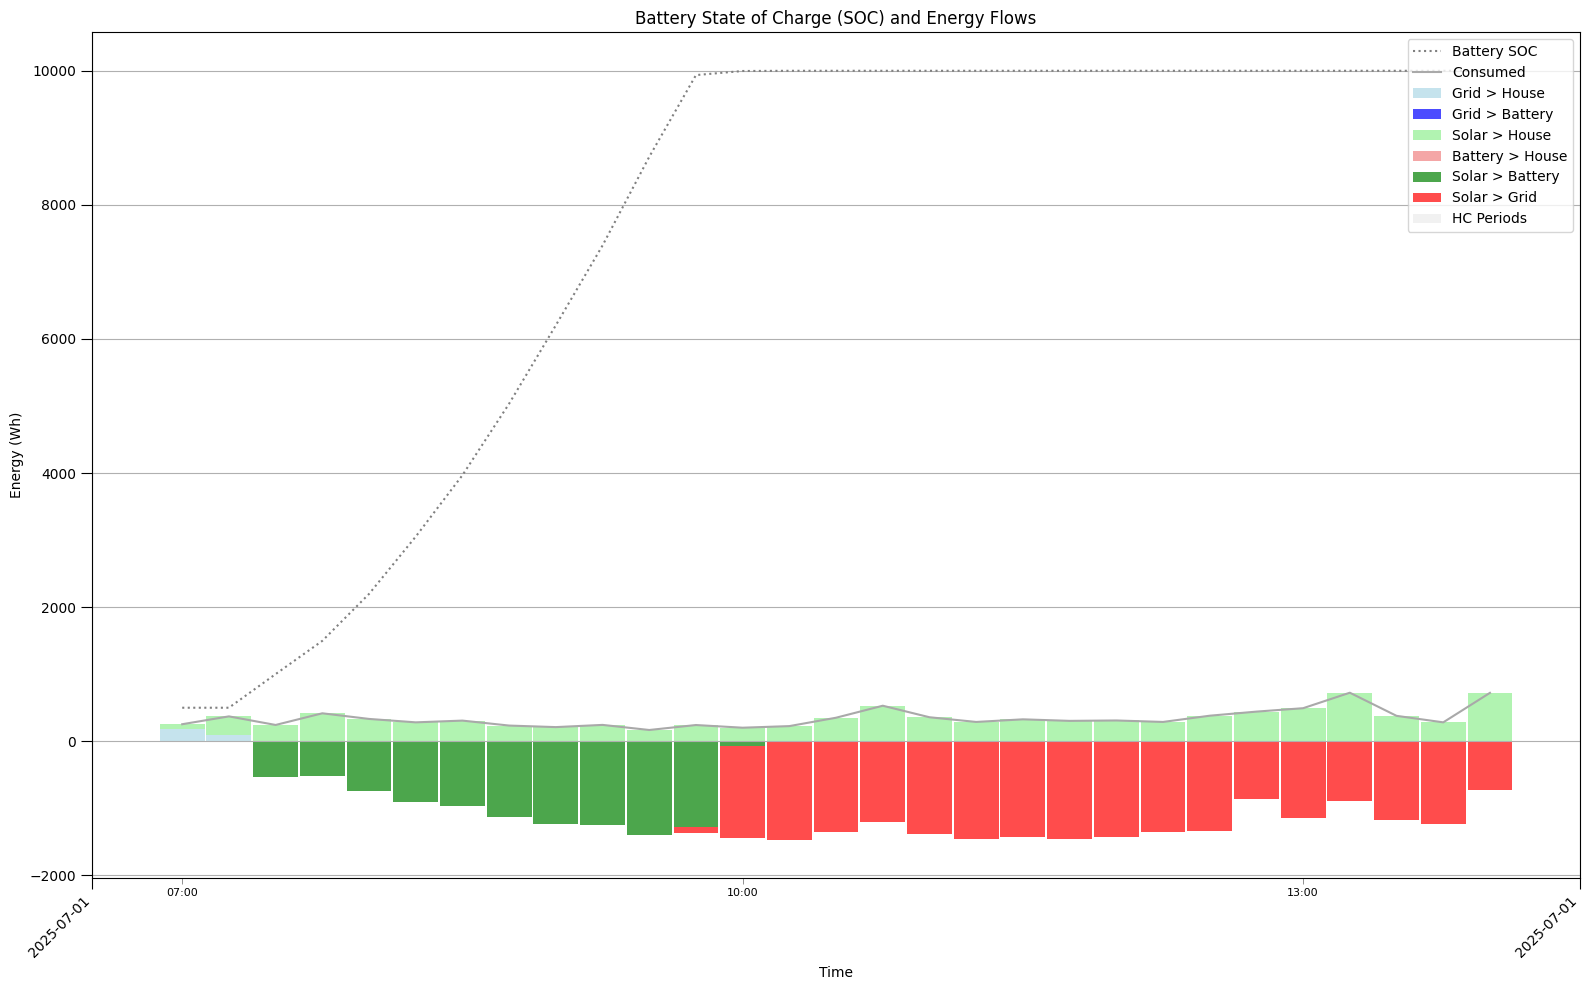

HP Cost  HP kWh  HC Cost  HC kWh  \
Category Type                                                             
Metric   Grid > House                     2.06    9.91        0     0.0   
         Grid > Battery                   0.00    0.00        0     0.0   
         Solar > House                   -2.01   -9.64        0     0.0   
         Battery > House                  0.00    0.00        0     0.0   
         Solar > Battery                  1.00   10.00        0     0.0   
         Solar > Grid                    -2.14  -21.38        0     0.0   
         Subscription Fee                 0.47    0.00        0     0.0   
Savings  Solar Savings                   -4.14  -31.02        0     0.0   
         Battery Savings                  1.00   10.00        0     0.0   
         All Savings                     -3.14  -21.02        0     0.0   
Total    Total Imported (Grid > Any)      2.06    9.91        0     0.0   
         Total Exported (Any > Grid)     -2.14  -21.38        0     0.0   
         Total Consumed (Any > House)     0.06    0.28        0     0.0   
         Total Stored (Any > Battery)     1.00   10.00        0     0.0   
         Total Produced (Solar > Any)    -3.14  -21.02        0     0.0   
         Total Cost                       0.39  -11.47        0     0.0   

                                       Total Cost  Total kWh  
Category Type                                                 
Metric   Grid > House                        2.06       9.91  
         Grid > Battery                      0.00       0.00  
         Solar > House                      -2.01      -9.64  
         Battery > House                     0.00       0.00  
         Solar > Battery                     1.00      10.00  
         Solar > Grid                       -2.14     -21.38  
         Subscription Fee                    0.47       0.00  
Savings  Solar Savings                      -4.14     -31.02  
         Battery Savings                     1.00      10.00  
         All Savings                        -3.14     -21.02  
Total    Total Imported (Grid > Any)         2.06       9.91  
         Total Exported (Any > Grid)        -2.14     -21.38  
         Total Consumed (Any > House)        0.06       0.28  
         Total Stored (Any > Battery)        1.00      10.00  
         Total Produced (Solar > Any)       -3.14     -21.02  
         Total Cost                          0.39     -11.47

In [22]:
plot_battery_soc_v2(
    df_input, 
    start_date_text, 
    end_date_text,
    wh_price_high_eur,
    wh_price_low_eur,
    wh_price_sale_eur,
    subscription_monthly_fee_eur,
    plot_chart=True)

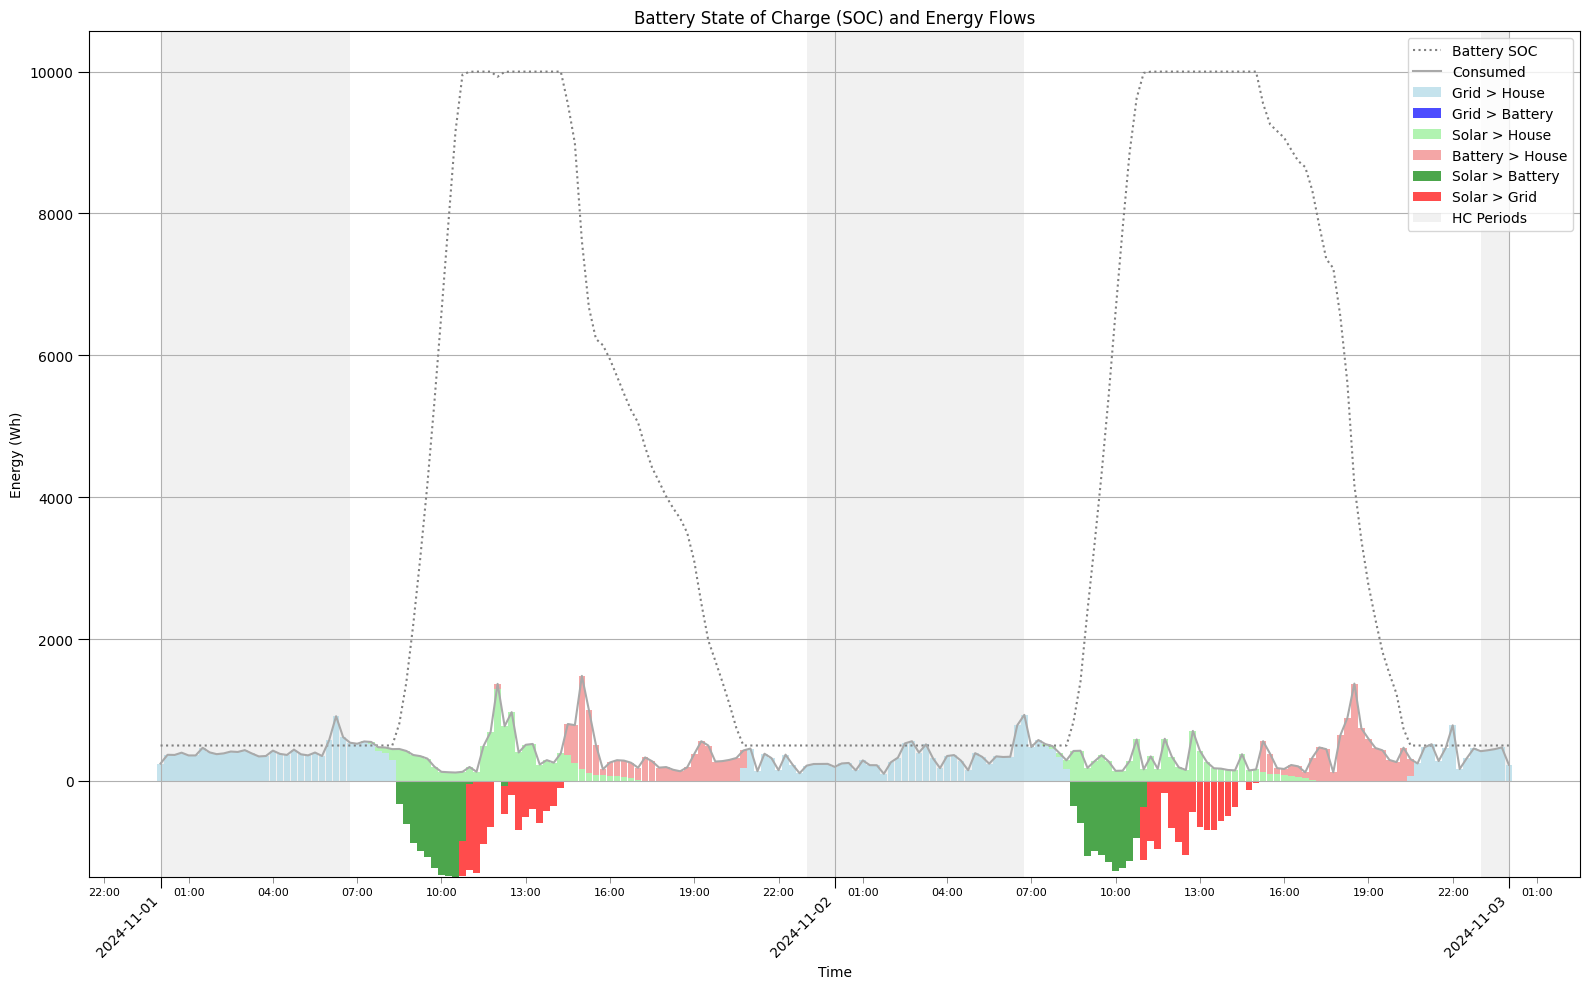

HP Cost  HP kWh  HC Cost  HC kWh  \
Category Type                                                             
Metric   Grid > House                     6.54   31.42     3.99   24.43   
         Grid > Battery                   0.00    0.00     0.00    0.00   
         Solar > House                   -4.18  -20.08     0.00    0.00   
         Battery > House                 -3.78  -18.14     0.00    0.00   
         Solar > Battery                  2.01   20.08     0.00    0.00   
         Solar > Grid                    -1.75  -17.54     0.00    0.00   
         Subscription Fee                 2.06    0.00     1.05    0.00   
Savings  Solar Savings                   -5.93  -37.62     0.00    0.00   
         Battery Savings                 -1.77    1.93     0.00    0.00   
         All Savings                     -7.70  -35.68     0.00    0.00   
Total    Total Imported (Grid > Any)      6.54   31.42     3.99   24.43   
         Total Exported (Any > Grid)     -1.75  -17.54     0.00    0.00   
         Total Consumed (Any > House)    -1.41   -6.79     3.99   24.43   
         Total Stored (Any > Battery)     2.01   20.08     0.00    0.00   
         Total Produced (Solar > Any)    -3.92  -17.54     0.00    0.00   
         Total Cost                       6.85   13.88     5.04   24.43   

                                       Total Cost  Total kWh  
Category Type                                                 
Metric   Grid > House                       10.53      55.86  
         Grid > Battery                      0.00       0.00  
         Solar > House                      -4.18     -20.08  
         Battery > House                    -3.78     -18.14  
         Solar > Battery                     2.01      20.08  
         Solar > Grid                       -1.75     -17.54  
         Subscription Fee                    3.11       0.00  
Savings  Solar Savings                      -5.93     -37.62  
         Battery Savings                    -1.77       1.93  
         All Savings                        -7.70     -35.68  
Total    Total Imported (Grid > Any)        10.53      55.86  
         Total Exported (Any > Grid)        -1.75     -17.54  
         Total Consumed (Any > House)        2.58      17.64  
         Total Stored (Any > Battery)        2.01      20.08  
         Total Produced (Solar > Any)       -3.92     -17.54  
         Total Cost                         11.89      38.32

In [23]:
plot_battery_soc_v2(
    results[-1]['data'], 
    "2024-11-01", 
    "2024-11-03",
    wh_price_high_eur,
    wh_price_low_eur,
    wh_price_sale_eur,
    subscription_monthly_fee_eur,
    plot_chart=True)

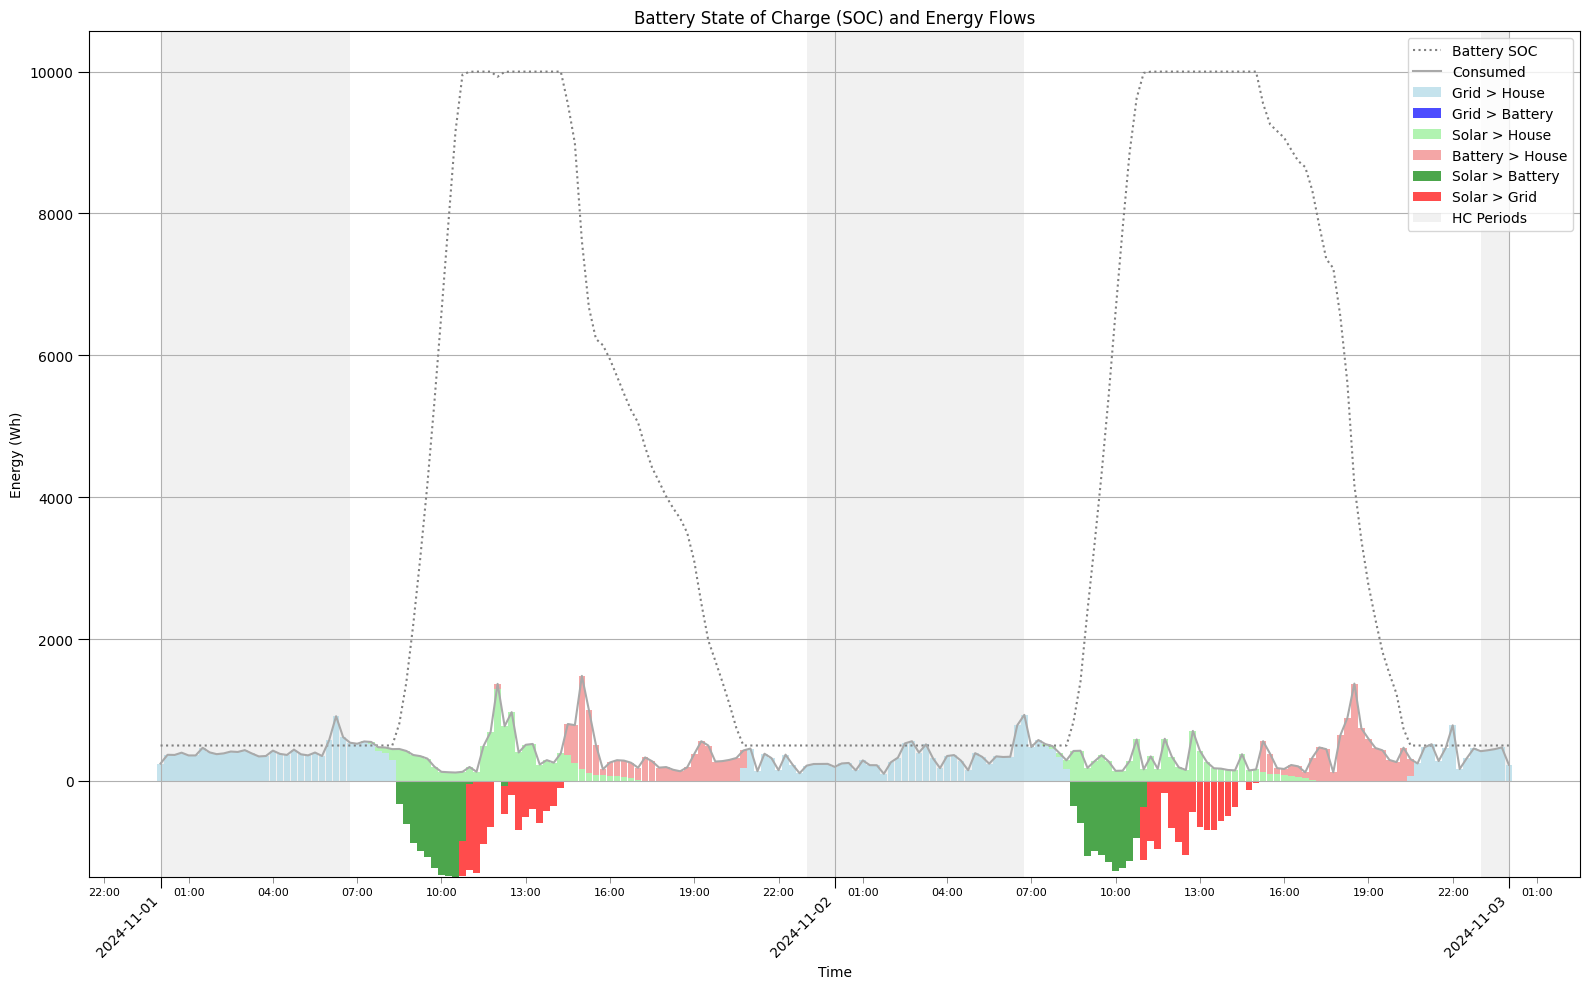

HP Cost  HP kWh  HC Cost  HC kWh  \
Category Type                                                             
Metric   Grid > House                     6.54   31.42     3.99   24.43   
         Grid > Battery                   0.00    0.00     0.00    0.00   
         Solar > House                   -4.18  -20.08     0.00    0.00   
         Battery > House                 -3.78  -18.14     0.00    0.00   
         Solar > Battery                  2.01   20.08     0.00    0.00   
         Solar > Grid                    -1.75  -17.54     0.00    0.00   
         Subscription Fee                 2.06    0.00     1.05    0.00   
Savings  Solar Savings                   -5.93  -37.62     0.00    0.00   
         Battery Savings                 -1.77    1.93     0.00    0.00   
         All Savings                     -7.70  -35.68     0.00    0.00   
Total    Total Imported (Grid > Any)      6.54   31.42     3.99   24.43   
         Total Exported (Any > Grid)     -1.75  -17.54     0.00    0.00   
         Total Consumed (Any > House)    -1.41   -6.79     3.99   24.43   
         Total Stored (Any > Battery)     2.01   20.08     0.00    0.00   
         Total Produced (Solar > Any)    -3.92  -17.54     0.00    0.00   
         Total Cost                       6.85   13.88     5.04   24.43   

                                       Total Cost  Total kWh  
Category Type                                                 
Metric   Grid > House                       10.53      55.86  
         Grid > Battery                      0.00       0.00  
         Solar > House                      -4.18     -20.08  
         Battery > House                    -3.78     -18.14  
         Solar > Battery                     2.01      20.08  
         Solar > Grid                       -1.75     -17.54  
         Subscription Fee                    3.11       0.00  
Savings  Solar Savings                      -5.93     -37.62  
         Battery Savings                    -1.77       1.93  
         All Savings                        -7.70     -35.68  
Total    Total Imported (Grid > Any)        10.53      55.86  
         Total Exported (Any > Grid)        -1.75     -17.54  
         Total Consumed (Any > House)        2.58      17.64  
         Total Stored (Any > Battery)        2.01      20.08  
         Total Produced (Solar > Any)       -3.92     -17.54  
         Total Cost                         11.89      38.32

In [24]:
plot_battery_soc_v2(
    results[-1]['data'], 
    "2024-11-01", 
    "2024-11-03",
    wh_price_high_eur,
    wh_price_low_eur,
    wh_price_sale_eur,
    subscription_monthly_fee_eur,
    plot_chart=True)

#### Full Year Report

In [25]:
plot_battery_soc_v2(
    results[-1]['data'], 
    "2024-09-01", 
    "2025-08-31",
    wh_price_high_eur,
    wh_price_low_eur,
    wh_price_sale_eur,
    subscription_monthly_fee_eur,
    plot_chart=False)

HP Cost   HP kWh  HC Cost   HC kWh  \
Category Type                                                               
Metric   Grid > House                  1061.92  5102.95   700.28  4283.08   
         Grid > Battery                   0.00     0.00     0.00     0.00   
         Solar > House                 -783.32 -3764.17    -2.07   -12.65   
         Battery > House               -413.09 -1985.05   -65.49  -400.57   
         Solar > Battery                263.79  2637.90     0.00     0.01   
         Solar > Grid                  -421.16 -4211.61     0.00     0.00   
         Subscription Fee               375.13     0.00   187.58     0.00   
Savings  Solar Savings                -1204.49 -7975.79    -2.07   -12.65   
         Battery Savings               -149.30   652.85   -65.49  -400.56   
         All Savings                  -1353.79 -7322.94   -67.56  -413.21   
Total    Total Imported (Grid > Any)   1061.92  5102.95   700.28  4283.08   
         Total Exported (Any > Grid)   -421.16 -4211.61     0.00     0.00   
         Total Consumed (Any > House)  -134.49  -646.28   632.72  3869.86   
         Total Stored (Any > Battery)   263.79  2637.90     0.00     0.01   
         Total Produced (Solar > Any)  -940.70 -5337.89    -2.07   -12.64   
         Total Cost                    1015.89   891.33   887.87  4283.08   

                                       Total Cost  Total kWh  
Category Type                                                 
Metric   Grid > House                     1762.21    9386.03  
         Grid > Battery                      0.00       0.00  
         Solar > House                    -785.39   -3776.82  
         Battery > House                  -478.58   -2385.63  
         Solar > Battery                   263.79    2637.91  
         Solar > Grid                     -421.16   -4211.61  
         Subscription Fee                  562.71       0.00  
Savings  Solar Savings                   -1206.55   -7988.44  
         Battery Savings                  -214.79     252.28  
         All Savings                     -1421.35   -7736.16  
Total    Total Imported (Grid > Any)      1762.21    9386.03  
         Total Exported (Any > Grid)      -421.16   -4211.61  
         Total Consumed (Any > House)      498.23    3223.58  
         Total Stored (Any > Battery)      263.79    2637.91  
         Total Produced (Solar > Any)     -942.76   -5350.53  
         Total Cost                       1903.76    5174.42